# Lecture 8: ground state approximation via VQE

<center><img src="../figures/qibo_mascotte/qibo_vqe.png" alt="drawing" width="400"/></center>
<center><strong>Fig. 8:</strong> Qibo the mangoose learning a VQE [DALL-E].</center>

In [3]:
# import numpy
import numpy as np
import matplotlib.pyplot as plt

# import qibo, Circuit, gates and hamiltonians
import qibo

from qibo import Circuit, gates, hamiltonians
from qibo import optimizers

from qiboedu.scripts.plotscripts import plot_vqe_states

qibo.set_backend("numpy")

[Qibo 0.2.7|INFO|2024-04-11 17:35:44]: Using numpy backend on /CPU:0


#### Problem setup: $H_{\rm target}$ and circuit $U(\theta)$

The goal of a VQE is to train a parametric quantum circuit to approximate the ground state of a target hamiltonian $H_{\rm target}.$
To this purpose, we need to define a target hamiltonian and a parametric circuit $U(\theta)$.

In [4]:
# define hamiltonian 
def build_hamiltonian(nqubits, h):
    """Build TFIM hamiltonian."""
    return hamiltonians.TFIM(nqubits=nqubits, h=h)

In [5]:
# define VQE function
def build_vqe_circuit(nqubits, nlayers):
    """Build VQE circuit."""
    c = Circuit(nqubits)
    for l in range(nlayers):
        for q in range(nqubits):
            c.add(gates.RY(q=q, theta=0))
            c.add(gates.RZ(q=q, theta=0))
        for q in range(0, nqubits-1, 1):
            c.add(gates.CNOT(q0=q, q1=q+1))
        c.add(gates.CNOT(q0=nqubits-1, q1=0))
    c.add(gates.M(*range(nqubits)))
    return c
            

#### Loss function definition

The loss function $J$ is the expectation value of the target hamiltonian over the final state one gets if executes the quantum circuit $U$:
$$ J = \langle 0 | U^{\dagger}(\theta) H_{\rm target} U(\theta) | 0 \rangle. $$
In this setup, we are searching for an optimal set of parameters $\theta$ such that the final state $| \psi \rangle = U(\theta)|0\rangle$ approximates the ground state of $H_{\rm target}.$ 

In [6]:
# define loss function
def loss_function(parameters, circuit, hamiltonian):
    """Compute the expval of hamiltonian after exec the VQE"""
    circuit.set_parameters(parameters)
    final_state = circuit().state()
    return hamiltonian.expectation(final_state)

#### Execution

In [7]:
# set number of qubits and layers (circuit architecture)
nqubits = 4
nlayers = 4

# build circuit and draw it
c = build_vqe_circuit(nqubits, nlayers)
print(c.draw())

q0: ─RY─RZ─o─────X─RY─RZ─o─────X─RY─RZ─o─────X─RY─RZ─o─────X─M─
q1: ─RY─RZ─X─o───|─RY─RZ─X─o───|─RY─RZ─X─o───|─RY─RZ─X─o───|─M─
q2: ─RY─RZ───X─o─|─RY─RZ───X─o─|─RY─RZ───X─o─|─RY─RZ───X─o─|─M─
q3: ─RY─RZ─────X─o─RY─RZ─────X─o─RY─RZ─────X─o─RY─RZ─────X─o─M─


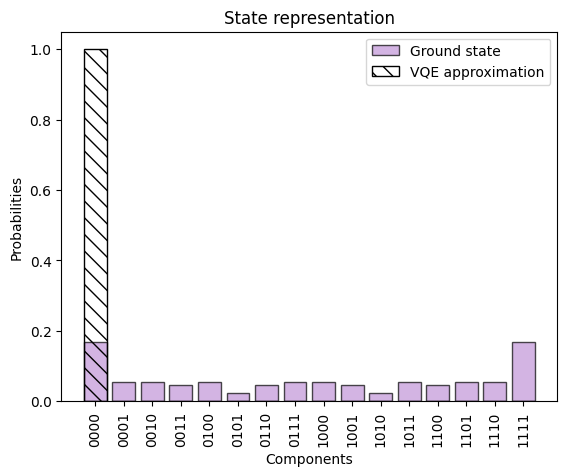

In [8]:
# build hamiltonian and collect ground state
h = build_hamiltonian(nqubits=nqubits, h=2)
ground_state = h.ground_state()

# plot ground state VS VQE's state
plot_vqe_states(ground_state, c().state())

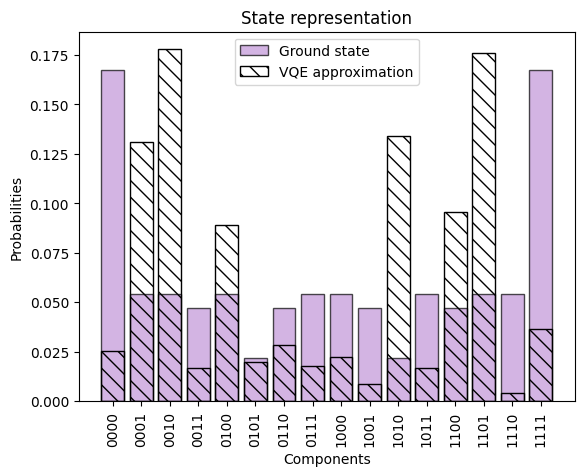

In [9]:
# set initial parameters
np.random.seed(42)
nparams = len(c.get_parameters())
init_p = np.random.randn(nparams)

# final state after execution with random parameters
c.set_parameters(init_p)

# plot 
plot_vqe_states(ground_state, c().state())

In [10]:
# optimize and
# collect optimization results
result = optimizers.optimize(
    loss = loss_function,
    initial_parameters=init_p,
    args = (c, h),
    method = "Powell"
)

In [11]:
result

(-8.542527380073851,
 array([-1.96615004e+00, -8.25909456e-01, -8.63022836e-01,  1.56007476e+00,
        -1.57575715e+00,  1.34650500e-03,  2.64044207e+00, -8.23427501e-02,
         1.59806752e+00,  1.13181850e+00,  4.86563027e-01, -1.04557426e+00,
         1.55978678e+00, -2.88853898e+00, -1.58029957e+00, -7.01532012e-01,
        -1.46543569e-02,  3.02450197e-01,  1.28406152e-02, -1.25216023e+00,
         1.22442077e+00,  3.20441519e-01, -5.77461806e-01, -1.13645273e+00,
        -1.25357736e-01,  7.35585920e-01, -1.56835530e+00,  1.07683767e-02,
        -9.61504167e-01,  2.36622045e-02,  7.85078805e-02,  1.89025112e+00]),
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -8.542527380073851
        x: [-1.966e+00 -8.259e-01 ...  7.851e-02  1.890e+00]
      nit: 16
    direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
            ...
            [ 0.000e+00  0.000e+00 ...  1.000e

In [12]:
# best parameters
best_p = result[1]

print(best_p)

[-1.96615004e+00 -8.25909456e-01 -8.63022836e-01  1.56007476e+00
 -1.57575715e+00  1.34650500e-03  2.64044207e+00 -8.23427501e-02
  1.59806752e+00  1.13181850e+00  4.86563027e-01 -1.04557426e+00
  1.55978678e+00 -2.88853898e+00 -1.58029957e+00 -7.01532012e-01
 -1.46543569e-02  3.02450197e-01  1.28406152e-02 -1.25216023e+00
  1.22442077e+00  3.20441519e-01 -5.77461806e-01 -1.13645273e+00
 -1.25357736e-01  7.35585920e-01 -1.56835530e+00  1.07683767e-02
 -9.61504167e-01  2.36622045e-02  7.85078805e-02  1.89025112e+00]


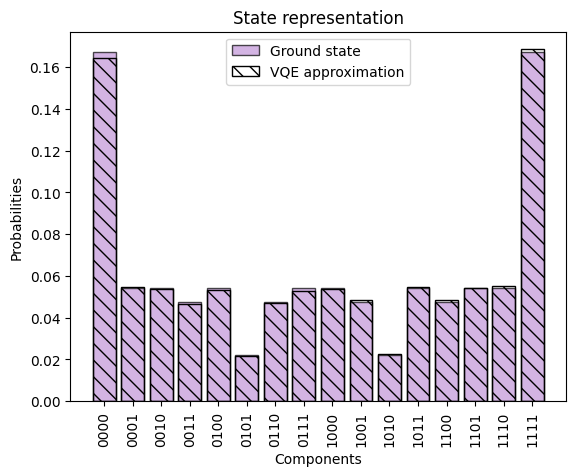

In [13]:
# set best parameters into the circuit
c.set_parameters(best_p)

# plot ground state VS VQE's state
plot_vqe_states(ground_state, c().state())